# Classification Prediction with Imbalanced Target

# Mary Donovan Martello

## The goal of this project was to design predictive binary classification models to predict whether credit card account holders will default on their payments in the next month. The models address the imbalance in the target variable. This notebook uses a Gradient Boosting Classification model to make the default prediciton.

# Part 5:  Gradient Boosting Classification Model

In [2]:
# import libraries

import pandas as pd
from pandas import read_csv
import numpy as np
from numpy import mean
from numpy import std
from numpy import argmax

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn import model_selection, metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#stop unnecessary warnings from printing to the screen
import warnings
warnings.simplefilter('ignore')



### This notebook uses two datasets. The first dataset includes the full data that was cleaned, prepared, and transformed into Principal Component features in the 1_EDA_Prep notebook. The second dataset is the first dataset that has been reduced to the best select features identified in the 2_Test_Subsets_of_Features notebook.

In [4]:
# Load data into a dataframe

df = pd.read_csv('pcaDefault.csv')


### Need a dataframe with dummy features for probability prediction and the classifier threshold.

In [77]:
# use only to create subsets

# convert categorical data to numbers 
#get the categorical data
cat_features = ['SEX', 'EDUCATION', 'MARRIAGE']
df_cat = df[cat_features]

# create dummy variable dataframe for categorical values 
dfDumm = pd.get_dummies(df_cat)

# check the data
print(dfDumm.head(4))

# create a whole features dataset that can be used for train and validation data splitting
# combine the numerical features and the dummie features together
dfNum = df.drop(['SEX', 'EDUCATION', 'MARRIAGE', 'default'], axis = 1)
X = pd.concat([dfNum, dfDumm], axis=1)
# create a whole target dataset that can be used for train and validation data splitting
y =  df['default']


   SEX  EDUCATION  MARRIAGE
0    1          1         2
1    1          2         2
2    1          1         1
3    2          2         2


Check the input features for testing feature subsets.

In [8]:
X.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'SEX',
       'EDUCATION', 'MARRIAGE'],
      dtype='object')

In [9]:
X.shape

(30000, 11)

## Model Selection and Evaluation

**Create Feature Dataframe for GridSearch Pipeline**

In [6]:

# separate into input and output columns (X variable for features and y for target variables)

Xp = df.drop('default', axis = 1) 
yP = df['default']
# will not label encode the target variable for random forest model
yRFp = df['default']

# one-hot encode input variables
# use ColumnTransformer to indicate which categorical variables to encode
# https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/
#https://github.com/scikit-learn/scikit-learn/issues/9132 to include categories = 'auto' when negative values in X
onehot_encoder = OneHotEncoder(categories='auto')
onehot_encoder.fit(Xp)
transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [8, 9, 10])], remainder='passthrough')
Xp = transformer.fit_transform(Xp)

# ordinal encode target variable
label_encoder = LabelEncoder()
label_encoder.fit(yP)
yP = label_encoder.transform(yP)


In [57]:
# custom confusion matrix function to show percentages
def conf_matrix(y,pred):
    ((tn, fp), (fn, tp)) = metrics.confusion_matrix(y, pred)
    
    return pd.DataFrame([[f'TN = {tn} (TNR = {tn / (tn+fp):1.2%})', 
                                f'FP = {fp} (FPR = {fp / (tn+fp):1.2%})'], 
                         [f'FN = {fn} (FNR = {fn / (fn+tp):1.2%})', 
                                f'TP = {tp} (TPR = {tp / (fn+tp):1.2%})']],
            index=['True 0(No Default)', 'True 1(Default)'], 
            columns=['Pred 0(No Default)', 
                            'Pred 1(Default)'])

**Phase 1: All input features with GridSearch and Stratified K-fold cross validation**

In [73]:
# grid search in a pipeline GradientBoostingClassifier 

#Create pipeline and gridsearch
modelGBC = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,
                                  min_samples_leaf=50,max_depth=8,max_features='sqrt', subsample=0.8,random_state=10)

param_GBC = {'n_estimators':range(20,81,10)}

grid = GridSearchCV(modelGBC, param_GBC, cv=5, verbose=0)

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'neg_log_loss']

# create a pipeline that standardizes, then runs logistic regression
#pipeline=make_pipeline(standardizer, grid)
pipeline=make_pipeline(grid)
# create k-fold cross-validation
skf= StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
# conduct a k-fold cross-validation
cv_results=cross_validate(pipeline, # Pipeline
                           Xp, # Feature matrix
                           yP,#target vector
                           cv=skf, # Cross-validation technique
                           scoring = scoring, # Loss function
                           n_jobs = -1)
#print(cv_results.mean())
print (cv_results)
print("results")

{'fit_time': array([105.49652982, 105.44068074, 105.37386155, 104.84926748,
       102.98407435, 102.3088882 , 102.72079206, 103.01100492,
        67.06047988,  66.79234815]), 'score_time': array([0.02692699, 0.03291106, 0.03689766, 0.0309124 , 0.02692652,
       0.02592874, 0.02791548, 0.03191328, 0.01562428, 0.01561999]), 'test_accuracy': array([0.79206931, 0.79073642, 0.79173609, 0.78973675, 0.792     ,
       0.79533333, 0.78826275, 0.79493164, 0.79593198, 0.79126375]), 'train_accuracy': array([0.80140005, 0.80136301, 0.80154821, 0.80228897, 0.79966667,
       0.79725926, 0.79997037, 0.80034073, 0.8035258 , 0.80137773]), 'test_precision_macro': array([0.70788009, 0.70285608, 0.71000769, 0.70038787, 0.71930439,
       0.74615385, 0.69444971, 0.72340667, 0.73019547, 0.70690747]), 'train_precision_macro': array([0.75587324, 0.74906947, 0.75401253, 0.75462032, 0.75571389,
       0.75105492, 0.7483037 , 0.74937041, 0.76105824, 0.75191811]), 'test_recall_macro': array([0.5673158 , 0.5643

**Phase 2: Best subset of features with GridSearch and Stratified K-fold cross validation**

In [74]:
# Best subset grid search in a pipeline GradientBoostingClassifier [classification metrics but not probability metrics]

#Create pipeline and gridsearch
modelGBC = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,
                                  min_samples_leaf=50,max_depth=8,max_features='sqrt', subsample=0.8,random_state=10)

param_GBC = {'n_estimators':range(20,81,10)}

grid = GridSearchCV(modelGBC, param_GBC, cv=5, verbose=0)

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'neg_log_loss']

# create a pipeline that standardizes, then runs logistic regression
#pipeline=make_pipeline(standardizer, grid)
pipeline=make_pipeline(grid)
# create k-fold cross-validation
skf= StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
# conduct a k-fold cross-validation
cv_results=cross_validate(pipeline, # Pipeline
                           subset7, # Feature matrix
                           yP,#target vector
                           cv=skf, # Cross-validation technique
                           scoring = scoring, # Loss function
                           n_jobs = -1)
#print(cv_results.mean())
print (cv_results)
print("results")

{'fit_time': array([68.99884987, 68.46028996, 68.33552408, 68.76437688, 78.3137548 ,
       78.13866425, 77.09956384, 77.60637927, 51.9342916 , 52.01435399]), 'score_time': array([0.02991939, 0.0289247 , 0.03091669, 0.03989053, 0.02220821,
       0.03034663, 0.02792478, 0.01915622, 0.03390527, 0.01894951]), 'test_accuracy': array([0.7994002 , 0.79606798, 0.80073309, 0.79473509, 0.80033333,
       0.804     , 0.79693231, 0.80526842, 0.80026676, 0.79393131]), 'train_accuracy': array([0.80673358, 0.80895589, 0.80943739, 0.80777066, 0.80718519,
       0.80592593, 0.80863672, 0.808933  , 0.80641458, 0.80941447]), 'test_precision_macro': array([0.72168221, 0.70906665, 0.72763244, 0.70710514, 0.72116889,
       0.74710701, 0.70872846, 0.7402017 , 0.72450686, 0.70041181]), 'train_precision_macro': array([0.74624754, 0.74987923, 0.7486613 , 0.74804551, 0.7453082 ,
       0.74716842, 0.74684093, 0.75162005, 0.74536397, 0.7524789 ]), 'test_recall_macro': array([0.59466331, 0.59198476, 0.59498005,

**Tune the Hyperparameters of the Gradient Boosting Classifier in Multiple Steps**

In [135]:
# will run muliple grid searches tuning different paramaters with best subset
# this first search tests for number of estimators

param_test1 = {'n_estimators':range(20,81,10)}

gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(subset7, yP)



GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_sa...      subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': range(20, 81, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [137]:
# this shows that the optimal number of estimators is 30; so below use 30 for n_estimators
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([1.51573997, 2.00842562, 1.73942161, 2.14182711, 2.40237098,
         2.71413798, 2.84190507]),
  'std_fit_time': array([0.0496384 , 0.31983727, 0.03028193, 0.06410582, 0.05765335,
         0.02046368, 0.28781283]),
  'mean_score_time': array([0.02473478, 0.01894865, 0.01914492, 0.02234106, 0.0253324 ,
         0.02793131, 0.02592916]),
  'std_score_time': array([0.01123739, 0.00302422, 0.00160199, 0.00195363, 0.00337167,
         0.00274978, 0.00432657]),
  'param_n_estimators': masked_array(data=[20, 30, 40, 50, 60, 70, 80],
               mask=[False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 20},
   {'n_estimators': 30},
   {'n_estimators': 40},
   {'n_estimators': 50},
   {'n_estimators': 60},
   {'n_estimators': 70},
   {'n_estimators': 80}],
  'split0_test_score': array([0.72988936, 0.74237666, 0.74551351, 0.74938992, 0.74653104,
         0.74362454, 0.74551657]),
  'spl

In [138]:
# will run muliple grid searches tuning different paramaters with best subset
# this second search tests for max depth and minimum sample split

param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt', 
                                                               subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(subset7, yP)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_




({'mean_fit_time': array([1.95796199, 1.91966152, 1.89672427, 2.01800027, 1.87458458,
         2.51387634, 2.44086914, 3.05881681, 3.28820024, 2.68900547,
         3.91316414, 3.15415854, 2.60962071, 2.83002915, 2.46480894,
         3.50721483, 3.35103459, 3.32290764, 2.93893771, 2.82624135,
         4.31425529, 3.98193979, 3.96060748, 3.96858153, 3.51639256,
         4.88772359, 5.13246741, 4.47263174, 5.09098325, 4.31545482]),
  'std_fit_time': array([0.04234898, 0.05444636, 0.07532702, 0.0884286 , 0.03394227,
         0.04165163, 0.08850959, 0.33341182, 0.4670742 , 0.14833003,
         0.11396859, 0.39798636, 0.06897823, 0.1018066 , 0.03198859,
         0.06318975, 0.22501457, 0.18292399, 0.0454225 , 0.04309671,
         0.16600748, 0.10495771, 0.23186287, 0.34908043, 0.23188996,
         0.35109763, 0.10069708, 0.2342135 , 0.09133272, 0.50314173]),
  'mean_score_time': array([0.01835308, 0.02134438, 0.0177527 , 0.0197474 , 0.01914911,
         0.02513056, 0.02353759, 0.02752562, 0.

In [140]:
# will run muliple grid searches tuning different paramaters with best subset
# the above second search shows the best max-depth of 5 and min_samples_split of 600; will the max_depth value here and
# do a third grid search for other paramaters and test a higher value for min_smaples_split

param_test3 = {'min_samples_split':range(600,1200,200), 'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=30,max_depth=5,
                                                               max_features='sqrt', subsample=0.8, random_state=10),
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(subset7, yP)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_


({'mean_fit_time': array([0.86707883, 0.87825289, 0.85710731, 0.85790539, 0.87944722,
         0.86368918, 0.87785144, 0.86647987, 0.98616018, 1.0128911 ,
         0.9023808 , 0.85331597, 0.90517755, 0.87985072, 0.77293477]),
  'std_fit_time': array([0.01230689, 0.01374452, 0.02061888, 0.01383907, 0.02296256,
         0.00848736, 0.01346079, 0.02403024, 0.02959577, 0.02841641,
         0.01656853, 0.01519902, 0.01583933, 0.01918352, 0.06281139]),
  'mean_score_time': array([0.01256638, 0.0121644 , 0.01336417, 0.01256804, 0.01256676,
         0.01356258, 0.01276693, 0.01336365, 0.01336398, 0.01356273,
         0.01236663, 0.0141623 , 0.01216888, 0.01296043, 0.01196761]),
  'std_score_time': array([0.00135263, 0.000744  , 0.00048815, 0.00048973, 0.00135176,
         0.00184915, 0.00074619, 0.00299802, 0.0007972 , 0.00135386,
         0.00079746, 0.00132295, 0.00074425, 0.0006309 , 0.00126226]),
  'param_min_samples_leaf': masked_array(data=[30, 30, 30, 40, 40, 40, 50, 50, 50, 60, 60, 60,

In [146]:
# will run muliple grid searches tuning different paramaters with best subset
# the above third search shows the best min_samples_leaf of 50 and again min_samples_split of 600; will these values here and
# do a fourth grid search for other paramaters

param_test4 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=30,max_depth=5,max_features='sqrt', 
                                                               min_samples_split=600, min_samples_leaf=50, subsample=0.8, 
                                                               random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(subset7, yP)
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_



({'mean_fit_time': array([0.84992447, 0.84434085, 0.85192132, 0.86289177, 0.88902225,
         0.81142826]),
  'std_fit_time': array([0.03369336, 0.01810264, 0.03338025, 0.0125274 , 0.01723638,
         0.08607607]),
  'mean_score_time': array([0.01416297, 0.01515851, 0.01296549, 0.01456103, 0.01296458,
         0.01117153]),
  'std_score_time': array([0.00074586, 0.00544013, 0.00209219, 0.00522359, 0.0012615 ,
         0.00171754]),
  'param_subsample': masked_array(data=[0.6, 0.7, 0.75, 0.8, 0.85, 0.9],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'subsample': 0.6},
   {'subsample': 0.7},
   {'subsample': 0.75},
   {'subsample': 0.8},
   {'subsample': 0.85},
   {'subsample': 0.9}],
  'split0_test_score': array([0.74626137, 0.73915722, 0.75611538, 0.76708441, 0.74206969,
         0.74462015]),
  'split1_test_score': array([0.88964261, 0.87663833, 0.88439384, 0.88555316, 0.88134703,
         0.877670

In [149]:
# Now we need to lower the learning rate and increase the number of estimators proportionally. Note that these trees might not 
# be the most optimum values but a good benchmark.

#Lets decrease the learning rate to half, i.e. 0.05 with twice (120) the number of trees.

gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=60,max_depth=5,max_features='sqrt', min_samples_split=600, min_samples_leaf=50, subsample=0.8, random_state=10)
gbm_tuned_1.fit(subset7, yP)
gbm_tuned_1

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=600,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              n_iter_no_change=None, presort='auto', random_state=10,
              subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

### Probability Predictions and Classification Threshold Selection

**Fit the model with best paramaters from the above GridSearch**

In [ ]:
# create a best subset features dataframe to use in fitting the model
cat_features = ['SEX', 'EDUCATION', 'MARRIAGE']
df_cat = df[cat_features]
dfPCAsub7 = X.loc[:, ['PC7', 'PC1', 'PC8', 'PC2', 'PC4', 'PC3']]
Xsub7 = pd.concat([dfPCAsub7, df_cat], axis=1)
# create a whole target dataset that can be used for train and validation data splitting
y =  df['default']

In [78]:

# separate data into training and validation : best subset
XTrain, XTest, yTrain, yTest = train_test_split(Xsub7, y, stratify=y, test_size =0.3, random_state=11)

# fit the model with the best parameters from the tuning above
gbc = GradientBoostingClassifier(learning_rate=0.01, n_estimators=300,max_depth=5,max_features='sqrt', min_samples_split=600, 
                                      min_samples_leaf=50, subsample=0.8, random_state=10).fit(XTrain, yTrain)


**Make probability predictions to choose best classification threshold for imbalanced target.**

In [79]:
# choose the threshold with the Receiver Operating Characteristic curve and Youden's J statistic

# predict probabilities; the last part of this line keeps the probabilities for the positive outcome only
GBpredprob=gbc.predict_proba(XTest)[:,1]

# calculate roc curves
fpr, tpr, thresholds = metrics.roc_curve(yTest, GBpredprob)

# get the best threshold: Youden’s J statistic
J = tpr - fpr
from numpy import argmax
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.228647


In [82]:
# predprob are predicted possibilities for positive outcome prediction 
# allocate the probability predictions between 1 and 0 based on the best threshold
GBpredprob_tuned_thresh = np.where(GBpredprob >= 0.228647, 1, 0)

# custom confusion matrix with predictions (showing percentages)
conf_matGBthresh = conf_matrix(yTest, GBpredprob_tuned_thresh)
conf_matGBthresh

,Pred 0(No Default),Pred 1(Default)
True 0(No Default),TN = 5369 (TNR = 76.60%),FP = 1640 (FPR = 23.40%)
True 1(Default),FN = 748 (FNR = 37.57%),TP = 1243 (TPR = 62.43%)


**Visualize Confusion Matrix**

In [83]:
# need a different format of confusion matrix for visualizing the confusion matrix of predictions
from sklearn.metrics import confusion_matrix
conf_matGBthresh = confusion_matrix(yTest, GBpredprob_tuned_thresh)
print(conf_matGBthresh)

[[5369 1640]
 [ 748 1243]]


(array([0.5, 1.5]),
 [Text(0, 0.5, 'No Default Next Month'), Text(0, 1.5, 'Default Next Month')])

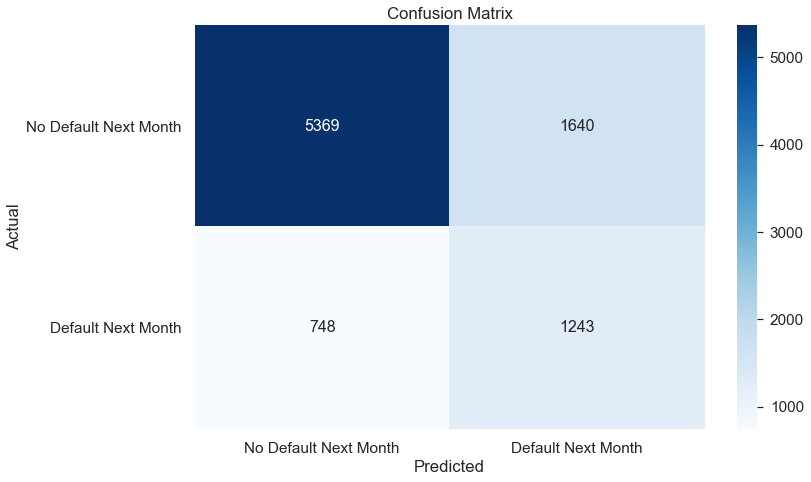

In [84]:
# seaborn confusion matrix
df_cm = pd.DataFrame(conf_matGBthresh, columns=np.unique(yP), index = np.unique(yP))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
x_axis_labels = ["No Default Next Month", "Default Next Month"] # labels for x-axis
y_axis_labels = ["No Default Next Month", "Default Next Month"] # labels for y-axis
sns.heatmap(df_cm, cmap="Blues", annot=True,fmt='g', annot_kws={"size": 16}, xticklabels=x_axis_labels, yticklabels=y_axis_labels)# font size
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("Actual")
plt.xlabel("Predicted")
# This sets the yticks "upright" with 0, as opposed to sideways with 90.
plt.yticks(rotation=0)

**Classification Report to View Evaluation Metrics**

<AxesSubplot:>

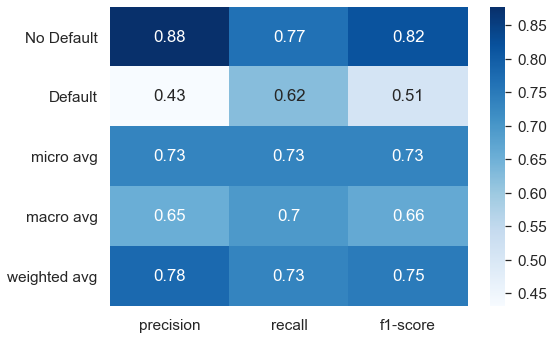

In [86]:
class_repGBthresh = classification_report(yTest, GBpredprob_tuned_thresh, output_dict=True, target_names= ['No Default', 'Default'])

# Create a dataframe from the dictionary and plot a heatmap of it.
# .iloc[:-1, :] to exclude support
sns.heatmap(pd.DataFrame(class_repGBthresh).iloc[:-1, :].T, annot=True, cmap="Blues")

In [87]:
import joblib
# save the predicted probabilities
filename = 'GB_predProb.sav'
joblib.dump(GBpredprob_tuned_thresh, filename)

['GB_predProb.sav']

**Calculate Loss Scores for Imbalanced Targets**

In [88]:
# loss scores with probabilities

from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_auc_score

# the probabilities of the predictions were calcaulated above [below is the code used above]
#predtst=gbc.predict_proba(XTest)[:,1]

# calculate log loss
# In the binary classification case, the function takes a list of true outcome values and a list of probabilities as arguments 
      # and calculates the average log loss for the predictions.
XGlossLog = log_loss(yTest, GBpredprob)
XGlossBrier = brier_score_loss(yTest, GBpredprob)
XGlossAUC = roc_auc_score(yTest, GBpredprob)
print('Log Loss Score: ', XGlossLog)
print('Brier Loss Score: ', XGlossBrier)
print('AUC Score: ', XGlossAUC)

Log Loss Score:  0.4545300130827825
Brier Loss Score:  0.14477935426317548
AUC Score:  0.7515136777218125
